In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import sys
sys.path.insert(0,'../data_utils/')
from HiCDataset import HiCDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style.txt')

In [18]:
chrom = '21'

# Large region
start_idx = 27_880_000
region_length = 2*1_280_000
'''
# Small region
start_idx = 29_000_000
region_length = 1_280_000
'''
resolution = 20_000

In [19]:
imr = pd.read_pickle(f'../../data/outside/dnase/IMR90_hg19_{chrom}.pkl')
gm = pd.read_pickle(f'../../data/outside/dnase/GM12878_hg19_{chrom}.pkl')

In [20]:
imr_hic = HiCDataset('../../data/outside/IMR90_hg19.mcool',resolution=resolution)
gm_hic = HiCDataset('../../data/outside/GM12878_hg19.mcool',resolution=resolution)

##### ASIDE: Locating regions with largest differences

import torch
dtype = torch.double
device = 'cuda' if torch.cuda.is_available() else 'cpu'

chr_len = imr.shape[-1]

Find the regions without missing data from both cooler files

def get_valid_hic_regions(clr,chrom=chrom,chr_len=chr_len,resolution=resolution,n_per_fetch=100):

    idx = range(n_per_fetch)
    mat=clr.matrix()
    diag_vals = []
    for start in range(0,chr_len,n_per_fetch*resolution):
        if start + n_per_fetch*resolution > chr_len:
            idx = range( (chr_len - start)//resolution )
            diag_vals.extend(mat.fetch(f'{chrom}:{start}-{chr_len}')[idx,idx])
            break
        diag_vals.extend(mat.fetch(f'{chrom}:{start}-{start+n_per_fetch*resolution}')[idx,idx])
    return torch.tensor(diag_vals).isfinite()

valid_hic_regions = get_valid_hic_regions(imr_hic.clr)
valid_hic_regions&= get_valid_hic_regions(gm_hic.clr)
valid_hic_regions = valid_hic_regions.to(device)
device = valid_hic_regions.device

Get the pearson correlation coefficient between regions in both DNase signals

from tqdm.auto import tqdm 

step_size = resolution # Number of positions to shift between each calculation
threshold_frac = .95   # Fraction of values that must be present to consider a region for visualization
thresh = threshold_frac * region_length
thresh1 = threshold_frac * (region_length//resolution)

signals = torch.stack(
    [
        torch.from_numpy(imr.toarray().flatten()),
        torch.from_numpy(gm.toarray().flatten())
    ],
    dim=0
).to(dtype=dtype,device=device)

corrcoefs = torch.empty(chr_len//step_size+1,device=device,dtype=dtype).fill_(torch.nan)
for i,start in tqdm(enumerate(range(0,chr_len,step_size)),total=chr_len//step_size+1):
    stop = start + region_length
    sig = signals[:,start:stop]
    sig = sig[:,torch.where(sig.isfinite().all(0))[0]]
    if sig.shape[-1] < thresh or valid_hic_regions[start//resolution:stop//resolution].sum() < thresh1:
        continue
    corrcoefs[i] = torch.corrcoef(signals[:,start:stop])[0,1]
plt.plot(np.arange(0,chr_len,step_size),corrcoefs.cpu().numpy())

corrcoefs.nan_to_num_(2)
start_idx = int(torch.where(corrcoefs==corrcoefs.min())[0]) * resolution

Back to the plotting...

Text(0, 0.5, 'DNase-seq\nSignal')

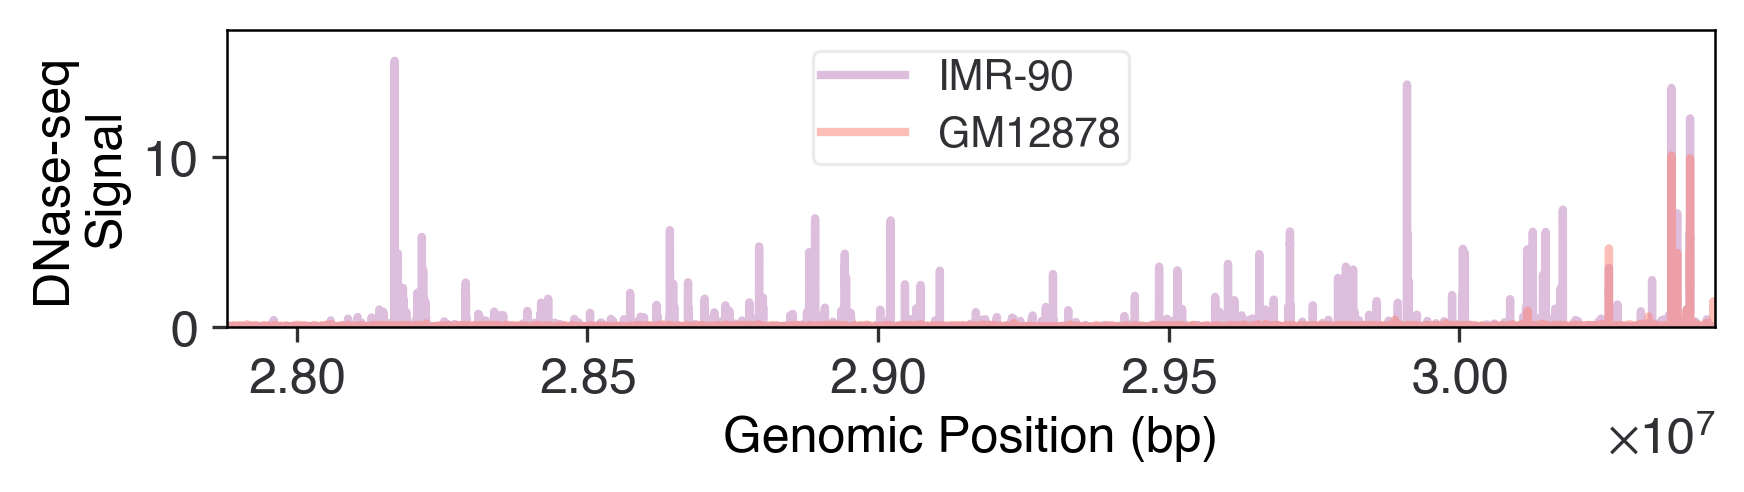

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
start = start_idx
stop = start + region_length
x = np.arange(start,stop)
ax.plot(x,imr[0,start:stop].toarray().flatten(),alpha=.5,label='IMR-90')
ax.plot(x,gm[0,start:stop].toarray().flatten(),alpha=.5,label='GM12878')
ax.set_xlim([start,stop])
ax.set_ylim([0,ax.get_ylim()[-1]])
ax.set_aspect(.2/ax.get_data_ratio(), adjustable='box')
ax.legend()
ax.set_xlabel('Genomic Position (bp)')
ax.set_ylabel('DNase-seq\nSignal')
#ax.set_title(f'DNase-seq signal comparison in chromosome {chrom}')

Text(0.64, 62.68, 'GM12878')

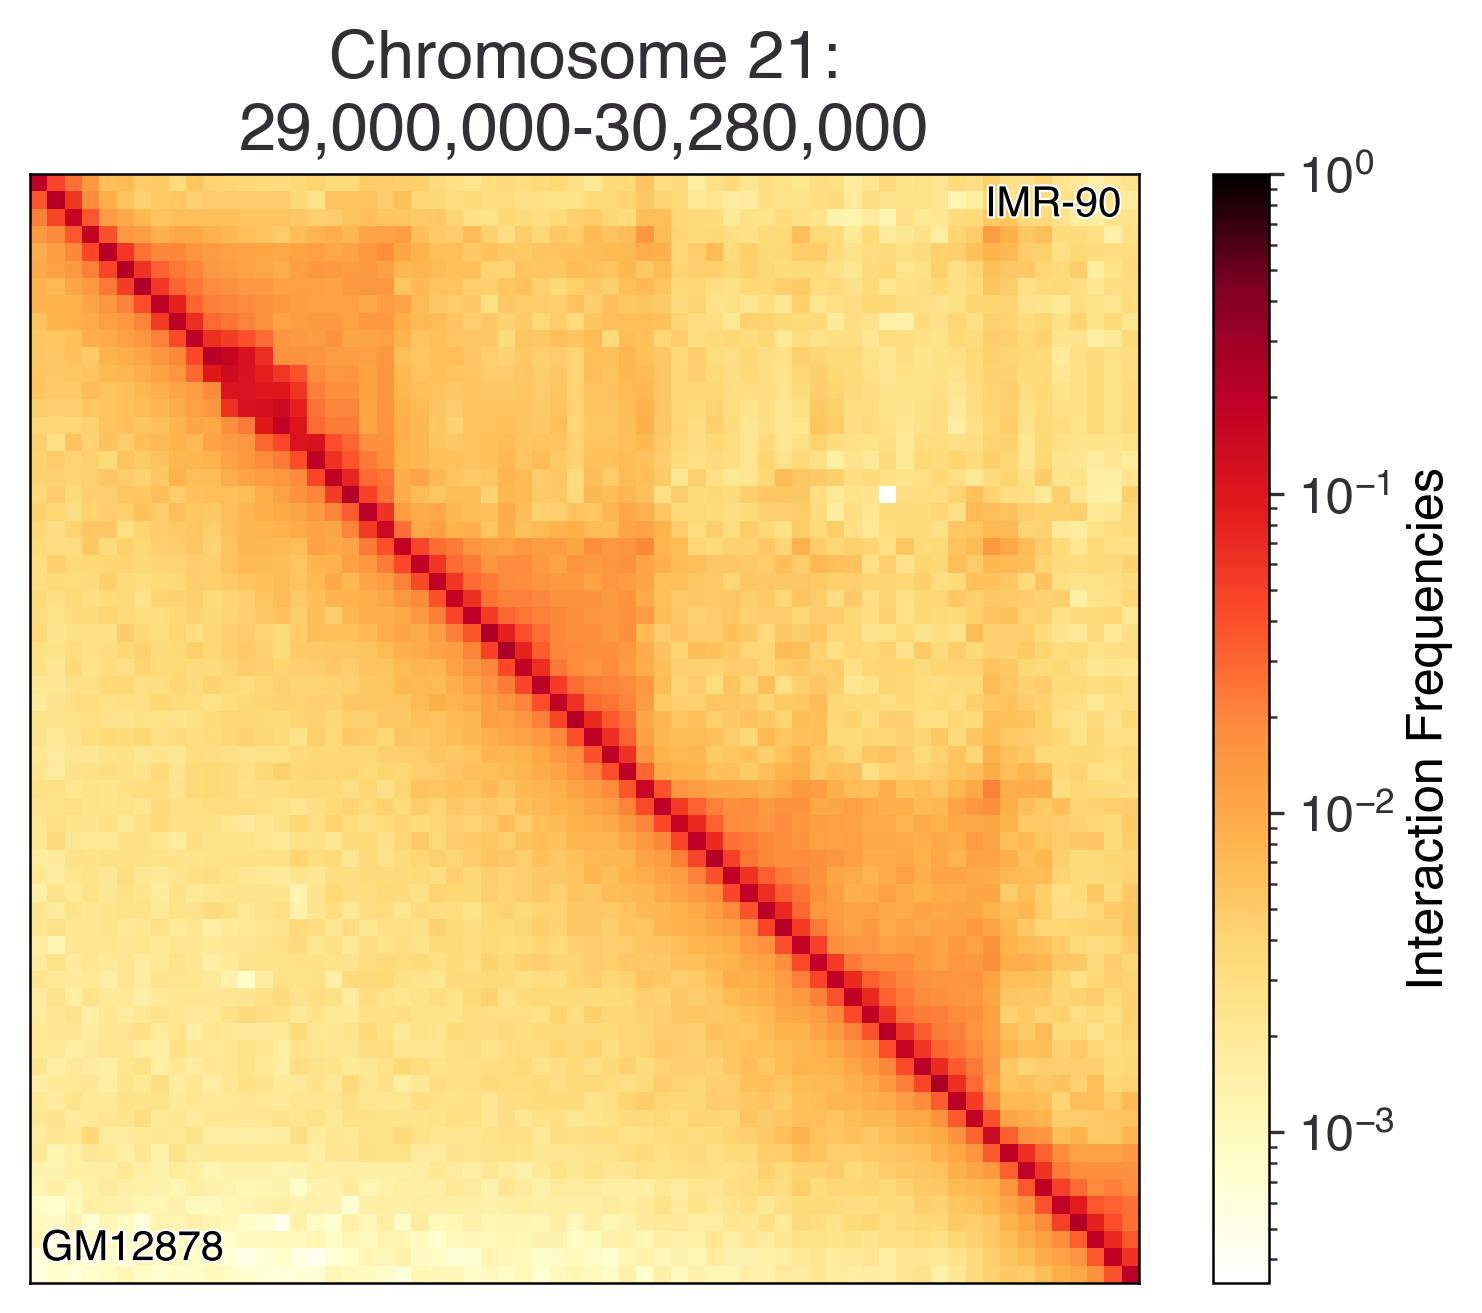

In [12]:
fig,ax,im,cbar = imr_hic.fetch(
    chrom=chrom,
    start=start,
    stop=stop,
    interp_nans=True
).plot_with(
    gm_hic.fetch(
        chrom=chrom,
        start=start,
        stop=stop,
        interp_nans=True
    )
)

ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{stop:,}')
num_bins = region_length//resolution
ax.text(num_bins-1,.01*num_bins,'IMR-90',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_bins,.995*num_bins-1,'GM12878',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

Text(0.64, 62.68, 'GM12878')

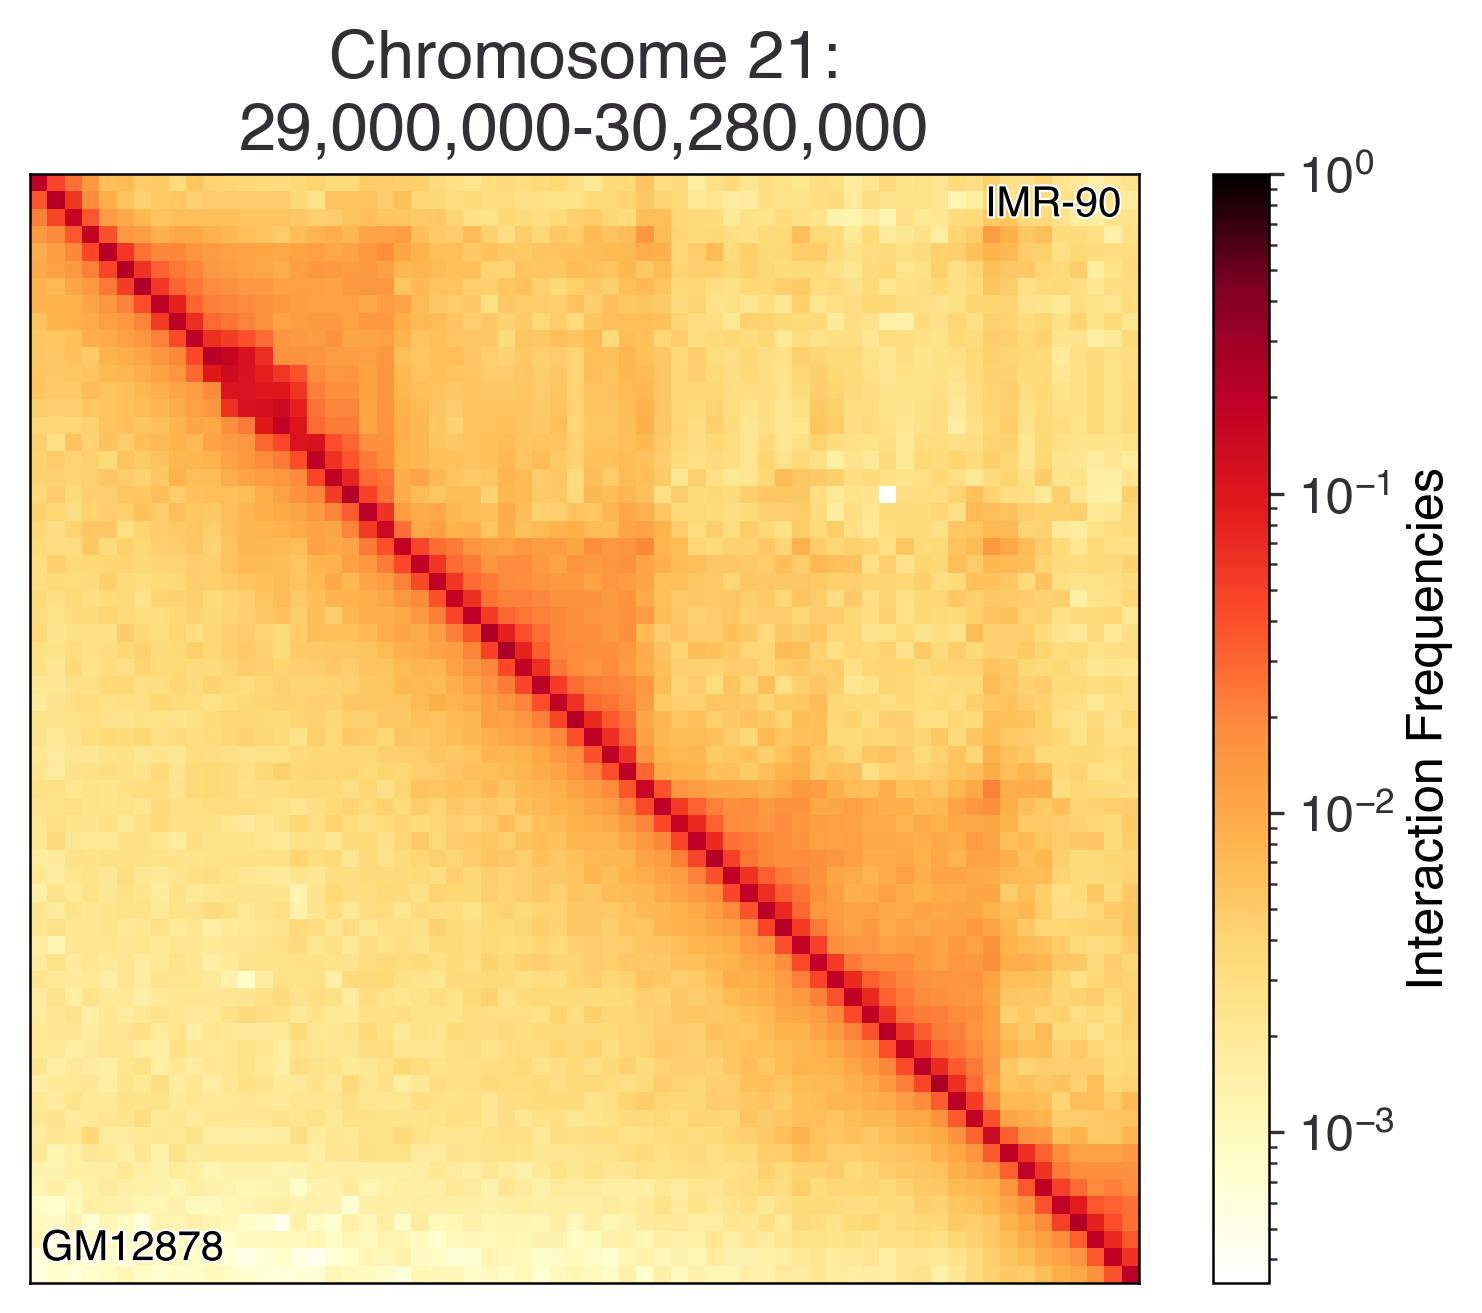

In [13]:
fig,ax,im,cbar = imr_hic.fetch(
    chrom=chrom,
    start=start,
    stop=stop,
    interp_nans=True
).plot_with(
    gm_hic.fetch(
        chrom=chrom,
        start=start,
        stop=stop,
        interp_nans=True
    )
)

ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{stop:,}')
num_bins = region_length//resolution
ax.text(num_bins-1,.01*num_bins,'IMR-90',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_bins,.995*num_bins-1,'GM12878',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

Text(0.64, 62.68, 'GM12878')

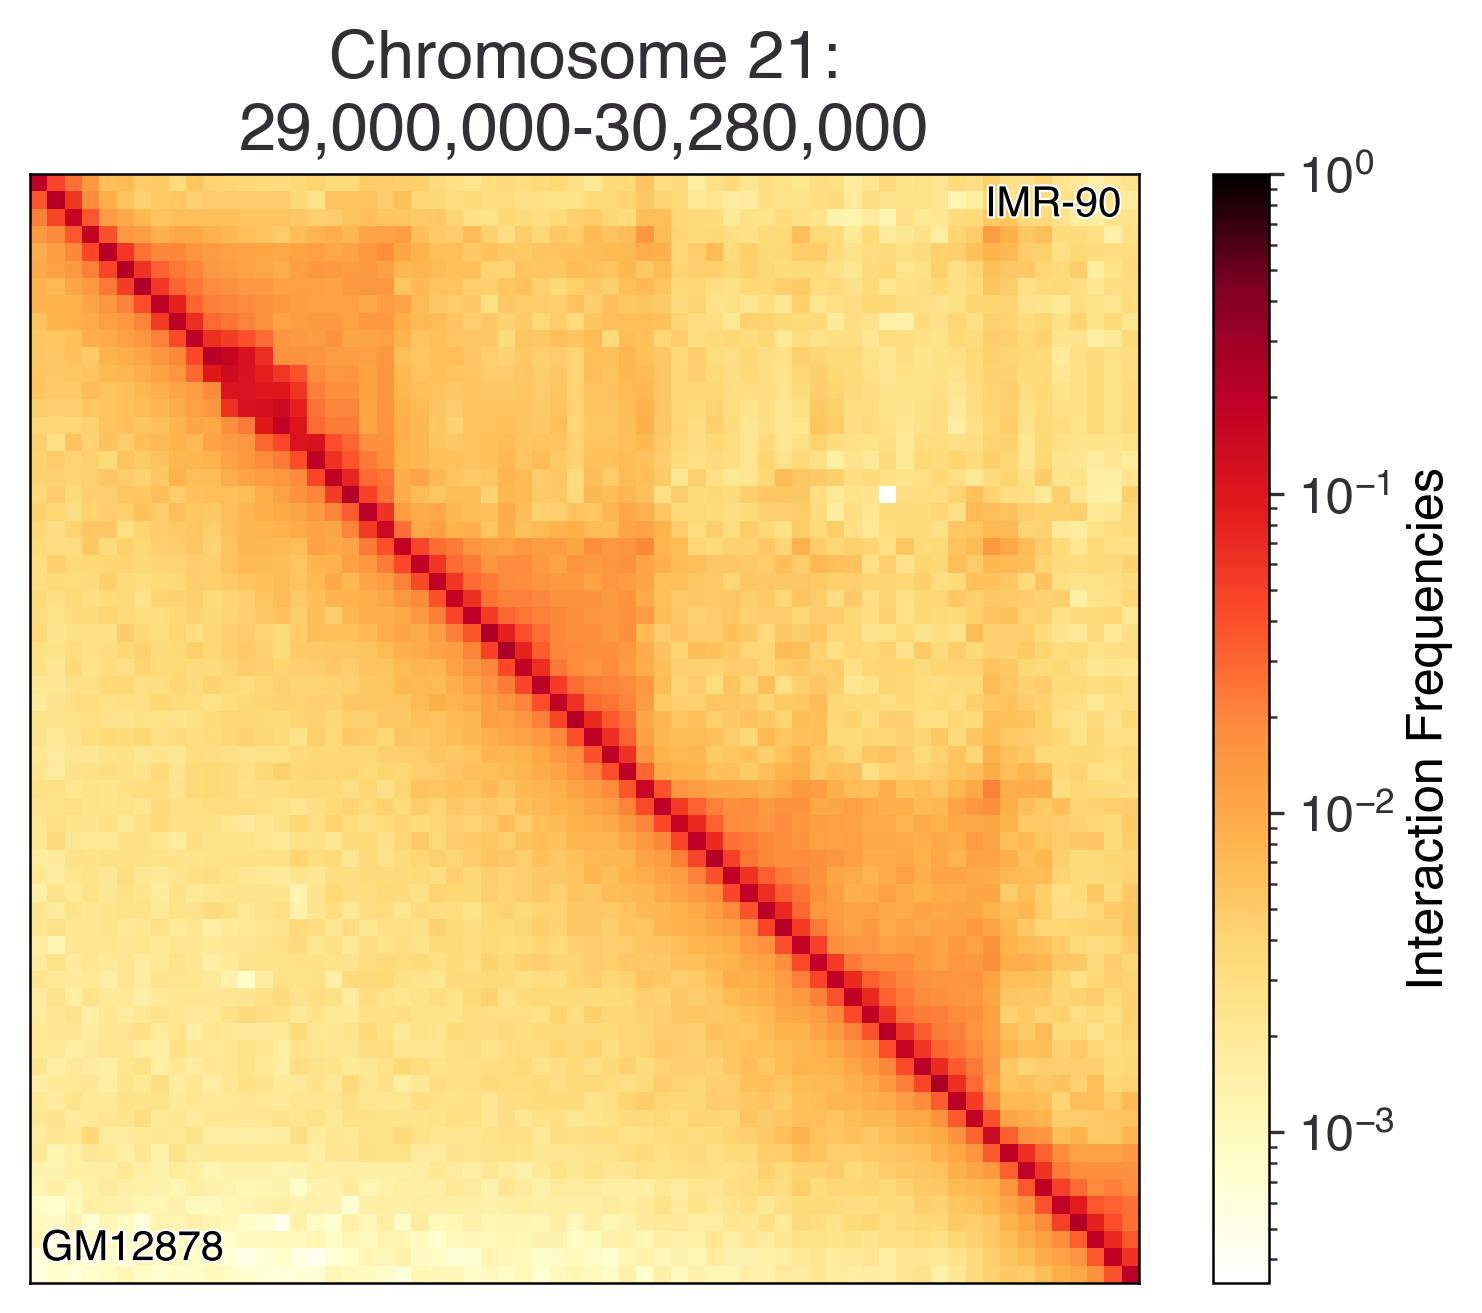

In [14]:
fig,ax,im,cbar = imr_hic.fetch(
    chrom=chrom,
    start=start,
    stop=stop,
    interp_nans=True
).plot_with(
    gm_hic.fetch(
        chrom=chrom,
        start=start,
        stop=stop,
        interp_nans=True
    )
)

ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{stop:,}')
num_bins = region_length//resolution
ax.text(num_bins-1,.01*num_bins,'IMR-90',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_bins,.995*num_bins-1,'GM12878',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])